In [4]:
#!pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install pytorch-lightning

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import List, Callable, Union, Any, TypeVar, Tuple
import pytorch_lightning as pl
import torchvision
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 19, 14)

class VAE(pl.LightningModule):
    def __init__(self, image_channels=3, h_dim=19*14*256, z_dim=32, lr = 1e-3):
        self.lr = lr
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=5, stride=2, padding = 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding = 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding = 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=10, stride=1, padding = 0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(256, 128, kernel_size=10, stride=1, padding = 0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding = 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding = 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=2, padding = 2, output_padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid(),
#             nn.Tanh(),
#             nn.LeakyReLU(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
#         print("x:",x.shape)
        h = self.encoder(x)
#         print("h:",h.shape)
        
        z, mu, logvar = self.bottleneck(h)
#         print("z:",z.shape)
        
        z = self.fc3(z)
        return [self.decoder(z), mu, logvar]
    
# ********************************************************************************************************************************
    
    def loss_fn(self, recon_x, x, mu, logvar):
#         print(recon_x)
#         print(x)
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
        return BCE + KLD
    
    
    def loss_function(self,recons,x,mu,logvar):
        # Account for the minibatch samples from the dataset; M_N = self.params['batch_size']/ self.num_train_imgs
        kld_weight = 0.5
        
#         recons_loss =F.mse_loss(recons, input)
        recons_loss =F.mse_loss(recons, x,reduction="sum")

#         kld_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
        kld_loss = torch.sum(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
        loss = recons_loss + kld_weight * kld_loss
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
#         optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
#         optimizer = torch.optim.RMSprop(self.parameters(), lr=1e-4)
#         optimizer = torch.optim.SGD(self.parameters(), lr=1e-5,momentum=0.9)
#         optimizer = torch.optim.Adagrad(self.parameters(), lr=1e-2)
        return optimizer
    
    counter=0
    
    def training_step(self, train_batch, batch_idx):
        self.counter+=1
        x,y= train_batch
        x=x.float()
        z, mu, logvar = self(x)
        loss = self.loss_function(z, x,mu, logvar)
#         loss = self.loss_fn(z, x,mu, logvar)
        if self.counter%50 ==0:
            print(loss)
        self.log('train_loss', loss)
        return loss

In [59]:
data_path = 'celeba/4072/'
# data_path = 'F:\pycharm-workspace\PyTorch-VAE-master\dataset-celeba/aa'
dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=torchvision.transforms.ToTensor()
)
print(len(dataset))
print(dataset.class_to_idx)

# sets=torch.utils.data.random_split(dataset, [2000,611,200000], generator=torch.Generator().manual_seed(2147483647))
sets=torch.utils.data.random_split(dataset, [3800,50], generator=torch.Generator().manual_seed(2147483647))

train_loader = torch.utils.data.DataLoader(
    sets[0],
    batch_size=30,
    num_workers=0,
    shuffle=True
)
train_test_loader = torch.utils.data.DataLoader(
    sets[0],
    batch_size=1,
    num_workers=0,
)
test_loader = torch.utils.data.DataLoader(
    sets[1],
    batch_size=1,
    num_workers=0,
)

for batch in train_loader:
    x, y = batch
    print(x.shape,y.shape)
    break

3850
{'.ipynb_checkpoints': 0, 'dummy_label': 1}
torch.Size([30, 3, 218, 178]) torch.Size([30])


In [ ]:
model = VAE(image_channels=3,z_dim=16, lr =1e-5 )
trainer = pl.Trainer(auto_scale_batch_size=True , max_epochs = 2000) # train 次数在trainer里面改
trainer.fit(model, train_loader) # 不用valid

In [35]:
# !find $PWD | xargs ls -ld

In [2]:
chekpoint_path = "lightning_logs/version_13/checkpoints/epoch=12.ckpt"
model_resume = VAE.load_from_checkpoint(chekpoint_path,image_channels=3,z_dim=16, lr =1e-5 )
trainer = pl.Trainer(auto_scale_batch_size=True , max_epochs = 2000) # train 次数在trainer里面改
# trainer.fit(model_resume, train_loader) # 不用valid

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


*****************************************************************************************************************


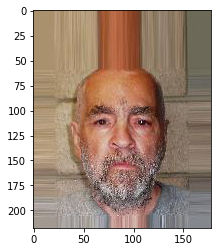

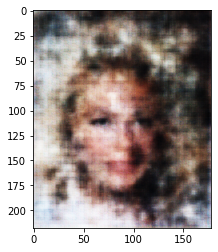

tensor([[[0.6627, 0.6627, 0.6627,  ..., 0.4235, 0.4235, 0.4235],
         [0.6627, 0.6627, 0.6627,  ..., 0.4235, 0.4235, 0.4235],
         [0.6627, 0.6627, 0.6627,  ..., 0.4235, 0.4235, 0.4235],
         ...,
         [0.6353, 0.6353, 0.6353,  ..., 0.5176, 0.5176, 0.5176],
         [0.6353, 0.6353, 0.6353,  ..., 0.5176, 0.5176, 0.5176],
         [0.6353, 0.6353, 0.6353,  ..., 0.5176, 0.5176, 0.5176]],

        [[0.5686, 0.5686, 0.5686,  ..., 0.4118, 0.4118, 0.4118],
         [0.5686, 0.5686, 0.5686,  ..., 0.4118, 0.4118, 0.4118],
         [0.5686, 0.5686, 0.5686,  ..., 0.4118, 0.4118, 0.4118],
         ...,
         [0.6000, 0.6000, 0.6000,  ..., 0.5294, 0.5294, 0.5294],
         [0.6000, 0.6000, 0.6000,  ..., 0.5294, 0.5294, 0.5294],
         [0.6000, 0.6000, 0.6000,  ..., 0.5294, 0.5294, 0.5294]],

        [[0.4275, 0.4275, 0.4275,  ..., 0.3451, 0.3451, 0.3451],
         [0.4275, 0.4275, 0.4275,  ..., 0.3451, 0.3451, 0.3451],
         [0.4275, 0.4275, 0.4275,  ..., 0.3451, 0.3451, 0.

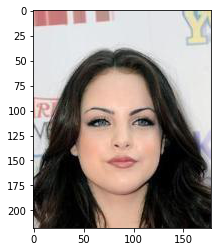

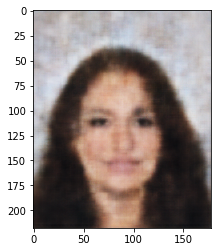

tensor([[[0.8471, 0.8588, 0.7647,  ..., 0.9176, 0.9059, 0.9059],
         [0.8510, 0.8588, 0.7725,  ..., 0.8980, 0.9137, 0.9137],
         [0.8471, 0.8627, 0.7765,  ..., 0.8902, 0.9059, 0.9059],
         ...,
         [0.7412, 0.6902, 0.6510,  ..., 0.2039, 0.0902, 0.0902],
         [0.7373, 0.7020, 0.7216,  ..., 0.1647, 0.0588, 0.0588],
         [0.7059, 0.6745, 0.6902,  ..., 0.1451, 0.0510, 0.0510]],

        [[0.6078, 0.6078, 0.5098,  ..., 0.8588, 0.8706, 0.8706],
         [0.6000, 0.6078, 0.5059,  ..., 0.8510, 0.8784, 0.8784],
         [0.5961, 0.6078, 0.5098,  ..., 0.8471, 0.8667, 0.8667],
         ...,
         [0.7255, 0.6745, 0.6314,  ..., 0.2039, 0.0980, 0.0980],
         [0.7216, 0.6863, 0.7020,  ..., 0.1647, 0.0667, 0.0667],
         [0.6902, 0.6588, 0.6667,  ..., 0.1451, 0.0588, 0.0588]],

        [[0.5961, 0.6000, 0.5020,  ..., 0.6275, 0.6549, 0.6549],
         [0.5922, 0.6000, 0.5020,  ..., 0.6235, 0.6627, 0.6627],
         [0.5882, 0.6000, 0.5059,  ..., 0.6275, 0.6588, 0.

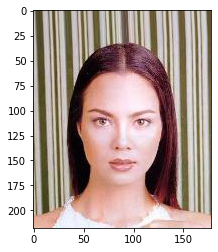

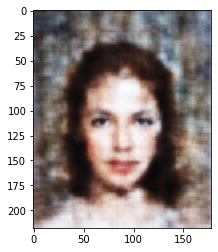

tensor([[[0.7961, 0.6902, 0.4588,  ..., 0.3725, 0.3882, 0.3882],
         [0.7961, 0.6941, 0.4627,  ..., 0.3725, 0.3882, 0.3882],
         [0.8000, 0.7020, 0.4706,  ..., 0.3725, 0.3882, 0.3882],
         ...,
         [0.8941, 0.8902, 0.8902,  ..., 0.9765, 0.9412, 0.9412],
         [0.9137, 0.9059, 0.9020,  ..., 0.9647, 0.9529, 0.9529],
         [0.9098, 0.9020, 0.8980,  ..., 0.9647, 0.9608, 0.9608]],

        [[0.7804, 0.6706, 0.4471,  ..., 0.3137, 0.3255, 0.3255],
         [0.7804, 0.6745, 0.4510,  ..., 0.3137, 0.3255, 0.3255],
         [0.7843, 0.6824, 0.4588,  ..., 0.3137, 0.3255, 0.3255],
         ...,
         [0.7059, 0.7020, 0.7020,  ..., 0.8431, 0.8314, 0.8314],
         [0.7333, 0.7255, 0.7216,  ..., 0.8314, 0.8510, 0.8510],
         [0.7333, 0.7255, 0.7216,  ..., 0.8392, 0.8588, 0.8588]],

        [[0.7686, 0.6471, 0.3882,  ..., 0.2235, 0.1922, 0.1922],
         [0.7686, 0.6510, 0.3922,  ..., 0.2235, 0.1922, 0.1922],
         [0.7725, 0.6588, 0.4000,  ..., 0.2235, 0.1922, 0.

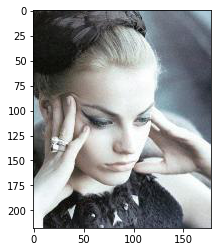

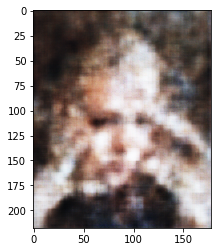

tensor([[[0.2039, 0.2235, 0.2118,  ..., 0.6627, 0.6745, 0.6745],
         [0.2157, 0.1843, 0.2078,  ..., 0.6588, 0.6784, 0.6784],
         [0.2078, 0.1216, 0.1804,  ..., 0.6588, 0.6706, 0.6706],
         ...,
         [0.9922, 0.9922, 0.9922,  ..., 0.7569, 0.7843, 0.7843],
         [1.0000, 0.9961, 0.9922,  ..., 0.7765, 0.7608, 0.7608],
         [1.0000, 0.9961, 0.9922,  ..., 0.7608, 0.7608, 0.7608]],

        [[0.2000, 0.2196, 0.2078,  ..., 0.7765, 0.7843, 0.7843],
         [0.2118, 0.1804, 0.2039,  ..., 0.7725, 0.7882, 0.7882],
         [0.2039, 0.1176, 0.1765,  ..., 0.7725, 0.7804, 0.7804],
         ...,
         [0.9922, 0.9922, 0.9922,  ..., 0.7608, 0.7961, 0.7961],
         [1.0000, 0.9961, 0.9922,  ..., 0.7804, 0.7725, 0.7725],
         [1.0000, 0.9961, 0.9922,  ..., 0.7647, 0.7725, 0.7725]],

        [[0.1843, 0.2039, 0.1922,  ..., 0.8392, 0.8314, 0.8314],
         [0.1961, 0.1647, 0.1882,  ..., 0.8353, 0.8353, 0.8353],
         [0.1882, 0.1020, 0.1608,  ..., 0.8353, 0.8275, 0.

In [92]:
# test:
import matplotlib.pyplot as plt
count = 0
for batch in train_test_loader:
# for batch in test_loader:
    count+=1;
    
    if count>=5:
        break
    print("*****************************************************************************************************************")
    x,y = batch
    plt.imshow(  x[0].permute(1, 2, 0)  )
    plt.show()
    z = model_resume(x)
#     print(z[0].shape)
#     print(type(z))
#     print(type(z[0]))
    z[0] = z[0].detach().view((3,218,178))
#     print(z[0].shape)

    plt.imshow(  z[0].permute(1, 2, 0)  )
    plt.show()
    print(x[0])
    print(z[0])

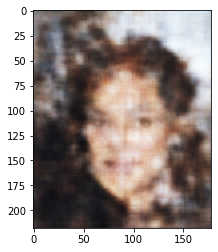

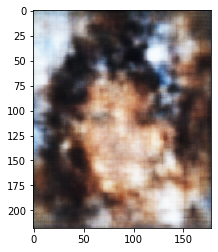

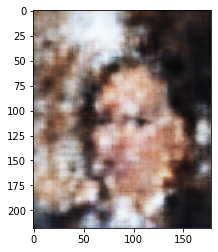

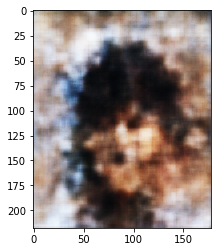

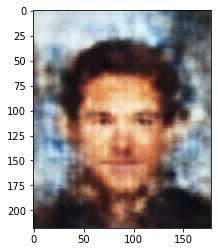

In [5]:
# 产生随机数据:
import matplotlib.pyplot as plt
for i in range(5):
#     fake = torch.randn(1,19*14*256)
    fake = torch.normal(0, 1, size=(1, 16))
    img = model_resume.decoder(model_resume.fc3(fake)).detach()
#     print(img.shape)
    plt.imshow(  img[0].permute(1, 2, 0)  )
    plt.show()